# Introduction

This document contains code for the exploratory analysis, training, and evaluation, of models for the LikeZero fake article detection exercise.

## Import Statements

In [29]:
import time
from pathlib import Path

import gensim.downloader as api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import utils

## Initialisation

Check Python Version:

In [2]:
py_version = !python --version
print("Version:", *py_version)

Version: Python 3.10.0


Download GloVe Embeddings and NLTK stopwords:

In [3]:
glove_model = api.load("glove-twitter-25")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aghou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

 Set the state of random number generation:

In [4]:
SEED = 1

np.random.seed(SEED)

## Load Data

In [5]:
DATA_DIR = Path('data/raw')
true_df = pd.read_csv(DATA_DIR / 'True.csv', parse_dates=['date']).dropna(how='all')
fake_df = pd.read_csv(DATA_DIR / 'Fake.csv', parse_dates=['date']).dropna(how='all')

In [6]:
true_df['IsFake'] = False
fake_df['IsFake'] = True

df = pd.concat((true_df, fake_df), axis=0, copy=False).reset_index()

## Summarise

First things first, let's get an overview of what the data looks like and a headline look at if there are any missing values and some summary stats.

In [7]:
with pd.option_context('display.max_colwidth', 150):
    display(pd.concat((true_df.sample(10, random_state=SEED),
            fake_df.sample(10, random_state=SEED)), axis=0))


title  \
13300                             Cambodian PM pulls back on threat to shut rights group founded by rival   
18707                                     UK court agrees to extradite suspect in Italy model kidnap plot   
14017                                         U.S. asks Venezuela for access to detained Citgo executives   
1883                                          U.S. to unveil revised self-driving car guidelines: sources   
2360                                          Court allows Democratic states to defend Obamacare payments   
7420                                        Democrat Hassan declares victory in New Hampshire Senate race   
14727        Memories in milk bottles: Polish exhibition 'shouts out' annihilation story of Warsaw Ghetto   
8325                                                       Trade critic Trump visits Boeing Co's backyard   
4438                                                 Senate set for pivotal vote on Supreme Court nominee   
16409                       Czech election winner Babis meets anti-EU party in hunt for viable government   
2378                         REPORT: Sean Spicer Forces Staffers To Surrender Phones In Search Of Leakers   
453                                   Very Suspicious Smoke Is Billowing Out Of Closing Russian Consulate   
2425    Trump Just Tried To ‘Compliment’ Democrat Keith Ellison. Ellison’s Response Is ALL Of Us (TWEETS)   
2979                           WATCH: Trump Doesn’t Want Us To Remember What He Said About Russia In 2014   
632                                     Elderly California Man Just Savaged A GOP Congressman To His FACE   
2336         BREAKING: Republican House Intel Chair THREATENS The Press After Asking About Russia (VIDEO)   
3493            ‘Big Baby’ Trump ‘Lied His ASS Off’: Seth Meyers Breaks Down Crooked Carrier Deal (VIDEO)   
3817                 Trump Supporters Didn’t Vote Because Of The Economy; It Was Racism, And Here’s PROOF   
644                     Five Times Five-Time Draft Dodger Donald Trump Insulted Those Who Actually Served   
2881                      Trump Escalates Confrontation With China In Move That Could Spark A Massive War   

                                                                                                                                                        text  \
13300  PHNOM PENH (Reuters) - Cambodian Prime Minister Hun Sen has pulled back from a threat to close a human rights group founded by the detained opposi...   
18707  LONDON (Reuters) - A man accused of being part of a plot to kidnap a British model in Milan should be extradited from Britain to Italy, a London j...   
14017  CARACAS (Reuters) - Washington has asked the government of leftist Nicolas Maduro for access to Venezuelan-American executives of U.S.-based refin...   
1883   WASHINGTON (Reuters) - President Donald Trump’s administration is set to unveil revised self-driving vehicle guidelines next week in Michigan, res...   
2360   WASHINGTON (Reuters) - A U.S. appeals court on Tuesday allowed Democratic state attorneys general to defend subsidy payments to insurance companie...   
7420   BOSTON (Reuters) - New Hampshire Governor Maggie Hassan, a Democrat, on Wednesday declared that she had won her race for the U.S. Senate, though l...   
14727  WARSAW (Reuters) - A deeply moving exhibition of archives documenting the life and annihilation of Jews by Nazi Germany in the Warsaw Ghetto durin...   
8325   EVERETT, Washington/WASHINGTON (Reuters) - Republican Donald Trump, who has made his criticism of a pending Pacific trade agreement central to his...   
4438   WASHINGTON (Reuters) - The U.S. Senate is set for a vote on Thursday that will test the resolve of Democratic opposition to President Donald Trump...   
16409  PRAGUE (Reuters) - Czech billionaire Andrej Babis s ANO party met an anti-European Union, anti-immigration group on Thursday in search of a coalit...   
2378   Donald Trump s paranoia and desperation to 

In [8]:
pd.concat((true_df.describe(include='all'),
          fake_df.describe(include='all')), axis=1)


title  \
count                                               21417   
unique                                              20826   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   14   
mean                                                  NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                                     text       subject  \
count                                               21417         21417   
unique                                              21192             2   
top     (Reuters) - Highlights for U.S. President Dona...  politicsNews   
freq                                                    8         11272   
mean                                                  NaN           NaN   
min                                                   NaN           NaN   
25%                                                   NaN           NaN   
50%                                                   NaN           NaN   
75%                                                   NaN           NaN   
max                                                   NaN           NaN   

                                 date IsFake  \
count                           21417  21417   
unique                            NaN      1   
top                               NaN  False   
freq                              NaN  21417   
mean    2017-06-03 23:46:00.890881280    NaN   
min               2016-01-13 00:00:00    NaN   
25%               2017-01-28 00:00:00    NaN   
50%               2017-09-13 00:00:00    NaN   
75%               2017-11-03 00:00:00    NaN   
max               2017-12-31 00:00:00    NaN   

                                                    title  \
count                                                4056   
unique                                               4055   
top      McConnell Says He’ll Obstruct ANY Effort To H...   
freq                                                    2   
mean                                                  NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                                     text subject  \
count                                                4056    4056   
unique                                               4056       1   
top     Donald Trump just couldn t wish all Americans ...    News   
freq                                                    1    4056   
mean                                                  NaN     NaN   
min                                                   NaN     NaN   
25%                                                   NaN     NaN   
50%                                                   NaN     NaN   
75%                                                   NaN     NaN   
max                                                   NaN     NaN   

                                 date IsFake  
count                            4056   4056  
unique                            NaN      1  
top                               NaN   True  
freq                              NaN   4056  
mean    2017-04-08 15:49:42.248520704    NaN  
min               2016-10-25 00:00:00    NaN  
25%               2017-01-12 00:00:00    NaN  
50%               2017-03-24 00:00:00    NaN  
75%               2017-06-26 00:00:00    NaN  
max               2017-12-31 00:00:00    NaN

Insights:
- I'm seeing a distinction in the encoding of some special characters between true and fake articles. This is likely a result of data collection inconsistencies and not from a true underlying feature of the data.
    - Suggest that we standardise common special characters e.g. converting `‘` to `'`.
- `text` not unique, will potentially need deduplication.
- `subject` contains limited information with only one category in `fake_df`.
- In general, we appear to have full data with no missing values.
- Both datasets contain data up to "2017-12-31", however, true articles are available from significantly further back in time. Using `date` as a feature is likely to introduce bias.

## Investivate Duplicates

The data appears to contain duplicate articles. I will be dropping these based
on the  `text` field, with the assumption being that even if all other
information is different, it is the article text itself that defines if an
article is a duplicate or not. 

In the case where two identical articles have the same date, I will keep the
record with the earliest date as naturally this is the original document.

In [9]:
dupe = df.duplicated(subset=['text'], keep=False)
dupe_w_title = df.duplicated(subset=['text', 'title'], keep=False)
dupe_w_date = df.duplicated(subset=['text', 'date'], keep=False)
dupe_w_flag = df.duplicated(subset=['text', 'IsFake'], keep=False)

print("Duplicate Texts:", dupe.sum())
print("Duplicate Text + Articles:", dupe_w_title.sum())
print("Duplicate Text + Date:", dupe_w_date.sum())
print("Duplicate Text + Fake Flag:", dupe_w_flag.sum())


Duplicate Texts: 437
Duplicate Text + Articles: 427
Duplicate Text + Date: 429
Duplicate Text + Fake Flag: 437


Insights:
- There are 225 duplicated `texts`.
- Five of these do not have the same `title`.
- Four of these do not have the `same` date.
- This number does not reduce when introducing the `IsFake` field.
  - i.e. there are no articles that are present in both the "real" and "fake" data.

Let's observe all of the duplicated `text`s that have different `title` or `date`.

In [10]:
pd.concat((df[dupe & ~dupe_w_date],
           df[dupe & ~dupe_w_title])).sort_values(['text', 'title', 'date'])

index                                              title  \
11228  11228  Exclusive: Atlantic City emergency fiscal mana...   
11227  11227  Exclusive: Atlantic City emergency fiscal mana...   
166      166  Factbox: What is in the U.S. Republicans' fina...   
165      165         What is in the Republicans' final tax bill   
17441  17441  Factbox - Battle for Raqqa, Islamic State's Sy...   
17444  17444  Factbox: Raqqa - Battle for Islamic State's Sy...   
11246  11246  For Republican Rubio, a moment of truth in rac...   
11239  11239  For Republican Rubio, a moment of truth in rac...   
8505    8505       Factbox: Why the Zika virus is causing alarm   
8481    8481       Factbox: Why the Zika virus is causing alarm   
11842  11842  Too late, Theresa - Brexit offer to EU citizen...   
11832  11832  Too late, Theresa: Brexit offer to EU citizens...   
250      250  Aide tries to refocus U.S. tax debate after Tr...   
250      250  Aide tries to refocus U.S. tax debate after Tr...   
247      247  Aide tries to refocus tax debate after Trump's...   
247      247  Aide tries to refocus tax debate after Trump's...   
4773    4773  Key conservative U.S. lawmaker says making hea...   
4772    4772  Key conservative lawmaker says making headway ...   

                                                    text       subject  \
11228  (Reuters) - New Jersey taxpayers will owe $2.6...  politicsNews   
11227  (Reuters) - New Jersey taxpayers will owe $2.6...  politicsNews   
166    (Reuters) - Republicans in the U.S. Congress r...  politicsNews   
165    (Reuters) - Republicans in the U.S. Congress r...  politicsNews   
17441  BEIRUT (Reuters) - The battle for the city of ...     worldnews   
17444  BEIRUT (Reuters) - The battle for the city of ...     worldnews   
11246  CHARLESTON, S.C. (Reuters) - Long viewed by th...  politicsNews   
11239  CHARLESTON, S.C. (Reuters) - Long viewed by th...  politicsNews   
8505   Global health officials are racing to better u...  politicsNews   
8481   Global health officials are racing to better u...  politicsNews   
11842  LONDON (Reuters) - Back from Brussels with a h...     worldnews   
11832  LONDON (Reuters) - Back from Brussels with a h...     worldnews   
250    WASHINGTON (Reuters) - President Donald Trump’...  politicsNews   
250    WASHINGTON (Reuters) - President Donald Trump’...  politicsNews   
247    WASHINGTON (Reuters) - President Donald Trump’...  politicsNews   
247    WASHINGTON (Reuters) - President Donald Trump’...  politicsNews   
4773   WASHINGTON (Reuters) - U.S. Representative Mar...  politicsNews   
4772   WASHINGTON (Reuters) - U.S. Representative Mar...  politicsNews   

            date  IsFake  
11228 2016-01-14   False  
11227 2016-01-15   False  
166   2017-12-14   False  
165   2017-12-14   False  
17441 2017-10-15   False  
17444 2017-10-15   False  
11246 2016-01-13   False  
11239 2016-01-14   False  
8505  2016-08-04   False  
8481  2016-08-11   False  
11842 2017-12-20   False  
11832 2017-12-20   False  
250   2017-12-07   False  
250   2017-12-07   False  
247   2017-12-08   False  
247   2017-12-08   False  
4773  2017-03-22   False  
4772  2017-03-22   False

In [11]:
# ## Reserve Test Dataset

# # Before commencing any analysis of the data, I want to ensure that I 

# TEST_PROPORTION = 0.2

# test_size = int(TEST_PROPORTION * len(df))

# df = df.sort_values('date')

# test_df = df.iloc[-test_size: ]
# df = df.iloc[: -test_size]

# print(f"Test frame shape: {test_df.shape}")
# print(f"Analysis frame shape: {df.shape}")

## Top-Level Analytics

- `title` length distribution
- `text` length distribution
- `date` distribution

In [12]:
# Calculate title length
df["title_len"] = df["title"].str.len()

# Calculate title length
df["text_len"] = df["text"].str.len()

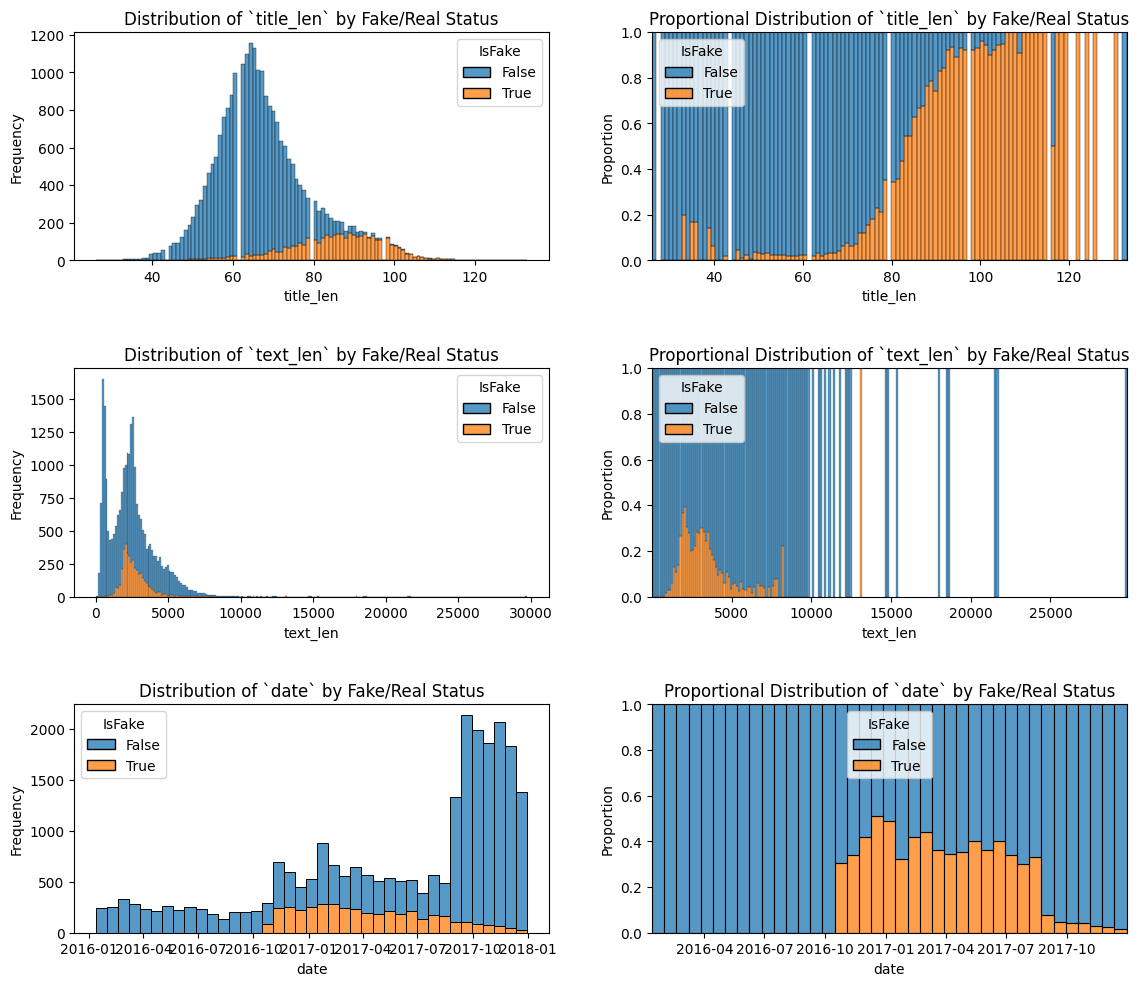

In [13]:
fields_to_plot = [
    'title_len',
    'text_len',
    'date']

utils.plot_histograms(df, fields_to_plot)

### Insights:
- Clearly text length and title length will make strong features. 
- Some engineering may be useful to isolate the two distributions for text length, if working with linear models.
- Fake articles progressively more prevelant as title length increases.
- Text length is a key distinguishing factor, long and short articles are significantly more likely to be legitimate.
  - Text appears to follow a mixture of distributions with a sharp peak for short articles followed by a wider peak for all other articles.
  - Interestingly, next to no fake articles are present in the first distribution (low number of words).
- As noted earlier, there is a key distinction in the date distributions.
  - No fake articles before `2016-10-25`.
  - Severely reduced fake article volumes following `2017-09`.

### Using Date Features Requires Caution

At first glance, using publication dates seems like an obvious predictive feature to include - dates could clearly provide a signal related to fake vs real articles over time. However, we need to consider potential issues with relying on raw temporal features given how our data was collected.

In examining our dataset, there appears to be significant temporal bias present. This likely stems from how examples were compiled over time rather than reflecting the true distribution of fake and real articles in the real world. Specifically, the volume and balance of examples earlier or later in our time window seem more related to data collection efforts rather than genuine patterns tied to veracity.

As we think about building a robust detector, we want to have confidence that it can generalise to accurately classify fake news in future time periods rather than just fitting nuances of our current dataset. Using raw date features directly risks learning spurious correlations that overfit to collection artifacts instead of meaningful signals.

Therefore, we should avoid using raw publication date as an input feature without careful consideration. A potential way to still leverage temporal effects could be to create transformed features, such as "day-of-week", "month", etc.

Clearly examples do not appear to be adding much in the way of substancial new information.

As such, I will remove all duplicate `text`s, taking the earliest `date` and the first `title`.

In [14]:
df = df.sort_values('date').drop_duplicates(subset=['text'], keep='first').sort_index()

## Fix Special Character Encodings

As noted in summarisation, we need to standardise special character encodings across the fake and real articles.

I will first compile a list of the most commonly used non-word characters in both and create a mapping to align these.

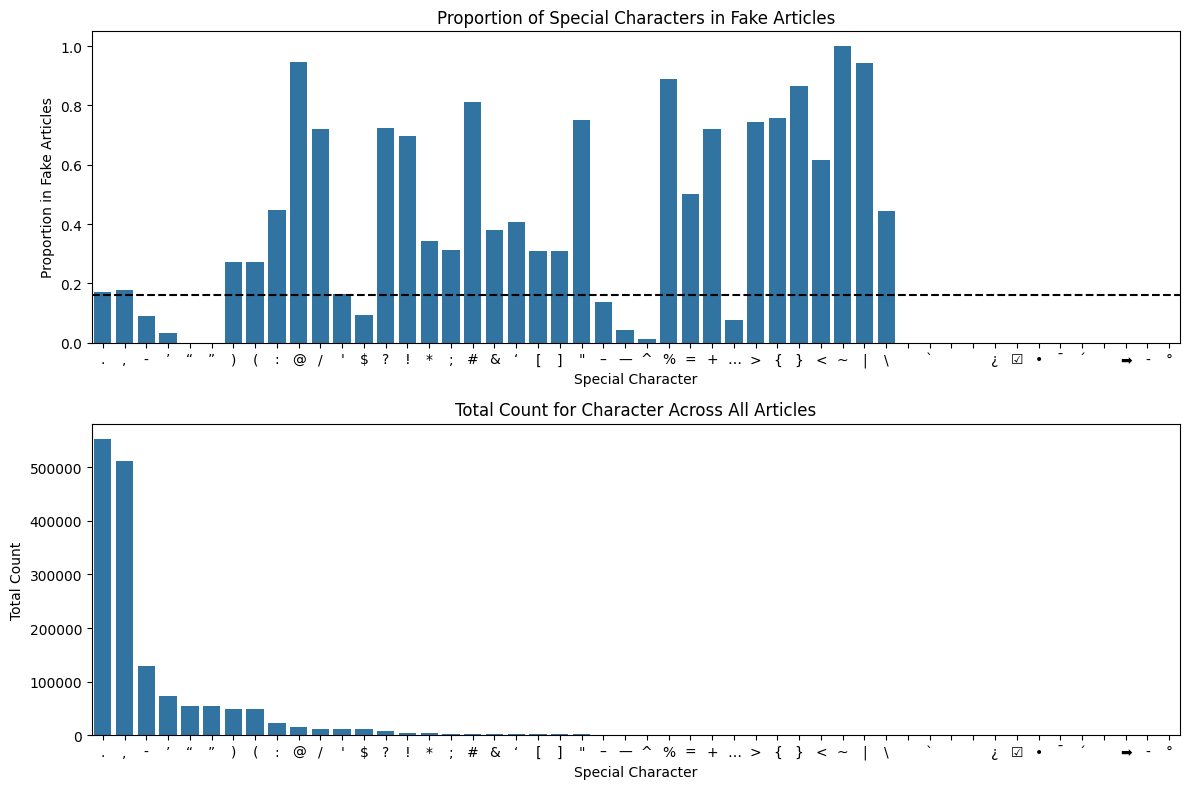

In [15]:


text_columns = ['title', 'text']
true_char_df = utils.get_special_char_prevalence(true_df, text_columns, 'True Count')
fake_char_df = utils.get_special_char_prevalence(fake_df, text_columns, 'Fake Count')

# Combine the dataframes and fill missing values
char_df = pd.merge(true_char_df, fake_char_df,
                   on='Char', how='outer').fillna(0)

# Add a column for totals
char_df['Total'] = char_df[['True Count', 'Fake Count']].sum(axis=1)
# Calculate proportions
char_df[['True Prop', 'Fake Prop']] = char_df[[
    'True Count', 'Fake Count']].div(char_df['Total'], axis=0)
# Sort values by 'Total' column
char_df = char_df.sort_values(by='Total', ascending=False)

# Plotting with seaborn
# Customize the size of the figure
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sns.barplot(data=char_df, x='Char', y='Fake Prop', ax=ax[0])
sns.barplot(data=char_df, x='Char', y='Total', ax=ax[1])

ax[0].set_title('Proportion of Special Characters in Fake Articles')
ax[0].set_ylabel('Proportion in Fake Articles')
ax[1].set_title('Total Count for Character Across All Articles')
ax[1].set_ylabel('Total Count')

# Add horizontal line indicating the expected proportion if distributions were identical.
ax[0].axhline(df['IsFake'].mean(), linestyle='--', color='black')

# Improve the appearance of the labels (rotate them if necessary)
for axis in ax:
    axis.set_xlabel('Special Character')

plt.tight_layout()  # Adjust the layout so everything fits in the figure
plt.show()


We can see a huge distinction in the use of special characters between true and fake articles, in general, fake articles appear to use rarer special characters far more frequently.

In the case of apostrophes and quotation marks. We can see that the typical encoding of these are barely used in the fake articles. This suggests to me that they were encoded differently at the collection stage, rather than this being an underlying and generalisable distinction between real and fake articles. As such, I will be converting all apostrophes and quotation marks to adhere to the same formatting.

For other special characters, the distinction appears to be a generalisable distinction, as `@` for example, doesn't have a clear substitute and yet features much more prevalently in the fake articles than real ones. I will be focusing significant feature engineering on capturing this distinction.

In [16]:


df['title'] = df['title'].apply(utils.standardize_text)
df['text'] = df['text'].apply(utils.standardize_text)

## Feature Engineering

I have a few ideas as to simple features that could be useful in extracting meaningful information:

1. **Capitalised Words**: More dramatic typography, like overusing capital letters, could signal text designed to elicit an emotional rather than informational response. This style is more common in fake news.
2. **Punctuation**: Similarly, excessive use of exclamation points or other punctuation may aim to provoke feelings over facts. This theory is bolstered by the split we see for special characters in above sections. We could analyse punctuation choices as an indicator.
3. **Day of week**: The way we interact with news stories is dependent on when (during the day / week) they are presented to us. Phenomena such as "Take Out the Trash Day" are well documented; where politicians intentionally leak bad news on a Thursday evening, so that it has the least impact on the public psyche. Could fake news be utilising similar mechanisms to drive engagement?
4. **Sentiment**: Fake news often wants high, "clickbaity" engagement. We may see more extreme sentiment, either positive or negative, compared to purely informational real news.
5. **Objectivity**: Real news likely contains more factual information whereas fake news speculates more freely. Assessing language objectivity could help differentiate them.

Other factors that could be considered but are outside the scope of this project:
- Readability
- Misspellings
- Length of sentences
- Use of expletives
- Part of speech tagging
- Named entities


### Word embeddings
In addition to engineered features, I will be using word embeddings to generate document level embeddings of the titles of documents.
To achieve this, I will take the following steps:
1. Tokenise the title, separating it into logical blocks (words, punctuation, etc.)
2. Remove stopwords - these are words such as `the` that won't add much in terms of syntactic meaning.
3. Get word embeddings for each token. This generates a vector representation of each token.
   - For this I used GloVe 25, a 25-dimensional embedding.
   - This is a relatively small and light-weight embedding, which will allow for faster inference and reduce the risk of overfitting.
   - If model predictions were insufficient, we could try alternative embeddings with increased dimensions and a larger training corpus. However, for the scope of this problem, `GloVe 25` provides the performance we need with significantly less compute required.
4. Pool word embeddings to document-level embeddings - for this I used mean pooling (averaging the embeddings element-wise). This decision could be experimented with in order to extract some extra performance.

In [17]:
# Temporal Features
start_time = time.time()
df['day_of_week'] = df['date'].dt.dayofweek
print(f'Temporal features took {time.time() - start_time:.2f} seconds')

# Capitalised
start_time = time.time()
for col in ['text', 'title']:
    df[f'{col}_len'] = df[col].str.len()
    df[f'{col}_capitalised_words_prop'] = df[col].apply(utils.get_capitalised)
print(f'Capitalised words processing took {time.time() - start_time:.2f}'
      ' seconds')

# Symbols
start_time = time.time()
for col in ['text', 'title']:
    for symbol in ['!', '?', '$', '/', '@', ':', ('(', ')')]:
        if isinstance(symbol, tuple):
            symbol_str = "".join(symbol)
        elif isinstance(symbol, str):
            symbol_str = symbol
        else:
            raise ValueError('Must be type str or tuple.')
        df[f'{col}_{symbol}_count_prop'] = df[col].apply(
            lambda x: utils.get_symbol_prop(x, symbol)
        )
    # For symbols using regular expressions
    df[f'{col}_symbol_count_prop'] = df[col].apply(
        lambda x: utils.get_symbol_prop(x, r'[^\w\s]', regex=True)
    )
print(f'Symbols processing took {time.time() - start_time:.2f} seconds')

# Sentiment and Subjectivity (Title)
start_time = time.time()
df[['title_sentiment', 'title_subjectivity']
   ] = df['title'].apply(utils.get_sent_subj_score)
print(
    f'Sentiment/Subjectivity for title took {time.time() - start_time:.2f}'
    ' seconds')

# # Sentiment and Subjectivity (Text)
# start_time = time.time()
# df[['text_sentiment', 'text_subjectivity']] = df['text'].apply(
#     utils.get_sent_subj_score)
# print(
#     f'Sentiment/Subjectivity for text took {time.time() - start_time:.2f}'
#     ' seconds')

# Embeddings (Title)
start_time = time.time()
df[[f'embedding_{i}' for i in range(25)]] = df['title'].apply(
    lambda x: utils.get_embeddings(x, glove_model))
print(f'Calculating embeddings took {time.time() - start_time:.2f} seconds')


Temporal features took 0.00 seconds
Capitalised words processing took 0.68 seconds
Symbols processing took 1.43 seconds
Sentiment/Subjectivity for title took 6.38 seconds
Calculating embeddings took 11.19 seconds


Sentiment and subjectivity score took **34.23 seconds** to generate. This is considerably longer than for all other features.

Based on above feature generation time of around **0.0008 seconds per article** were achieved with my hardware, an adequate result for high-velocity applications.

Assuming that we would prefer to keep inference time to a minimum, it was decided that sentiment and subjectivity would only be calculated for the `title`. 

This decreases the final model F1 from **0.9884** to **0.9808**. Please feel free to uncomment the relevant lines above for validation.

Similarly, embeddings are only calculated for the titles as this vastly reduces the time taken to compute features.

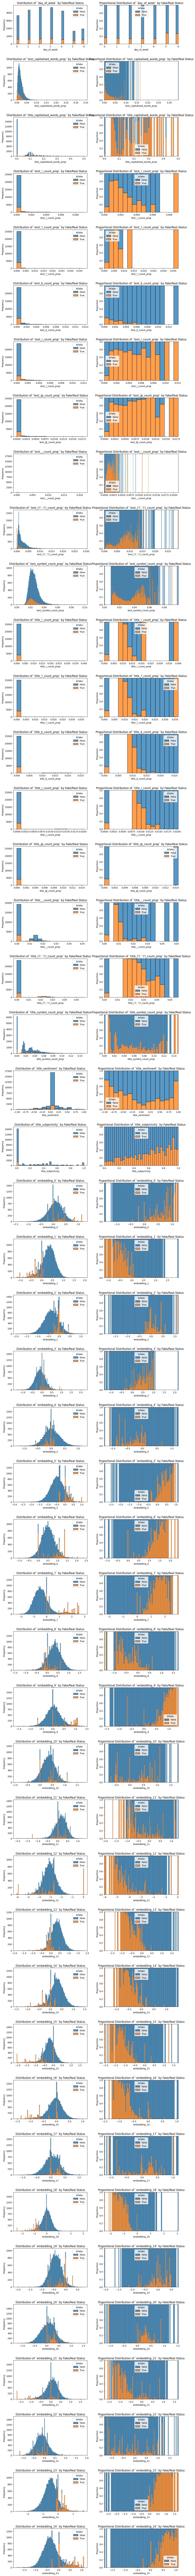

In [18]:

fields_to_plot = [
    'day_of_week',
    'text_capitalised_words_prop',
    'title_capitalised_words_prop',
    'text_!_count_prop',
    'text_?_count_prop',
    'text_$_count_prop',
    'text_/_count_prop',
    'text_@_count_prop',
    'text_:_count_prop',
    "text_('(', ')')_count_prop",
    'text_symbol_count_prop',
    'title_!_count_prop',
    'title_?_count_prop',
    'title_$_count_prop',
    'title_/_count_prop',
    'title_@_count_prop',
    'title_:_count_prop',
    "title_('(', ')')_count_prop",
    'title_symbol_count_prop',
    'title_sentiment',
    'title_subjectivity',
    'embedding_0',
    'embedding_1',
    'embedding_2',
    'embedding_3',
    'embedding_4',
    'embedding_5',
    'embedding_6',
    'embedding_7',
    'embedding_8',
    'embedding_9',
    'embedding_10',
    'embedding_11',
    'embedding_12',
    'embedding_13',
    'embedding_14',
    'embedding_15',
    'embedding_16',
    'embedding_17',
    'embedding_18',
    'embedding_19',
    'embedding_20',
    'embedding_21',
    'embedding_22',
    'embedding_23',
    'embedding_24']

utils.plot_histograms(df, fields_to_plot)

We can see clear separation in the classes for a number of features within our dataset.

Highlights:
- Strong evidence for title sentiment and subjectivity playing a key role in uncovering fake articles.
  - As expected, both positive and negative sentiment appear to be indicative of fake news.
  - This signal appears significantly muddier when computed on the entire text.
    - Suggest that we test using this as a feature but if only weakly predictive, we may want to remove it to allow for faster inference.
  - Sentiment is interesting as we can see polarity, either positive or negative, increases the likelihood of illegitimacy.
- Typographic features extracted from the title do not show clear trends 
- Evidence of separation in many of the embedding features.
- Any use of `@` or `/` significantly increases the likelihood of fakes.

# Heatmap of Feature Correlations

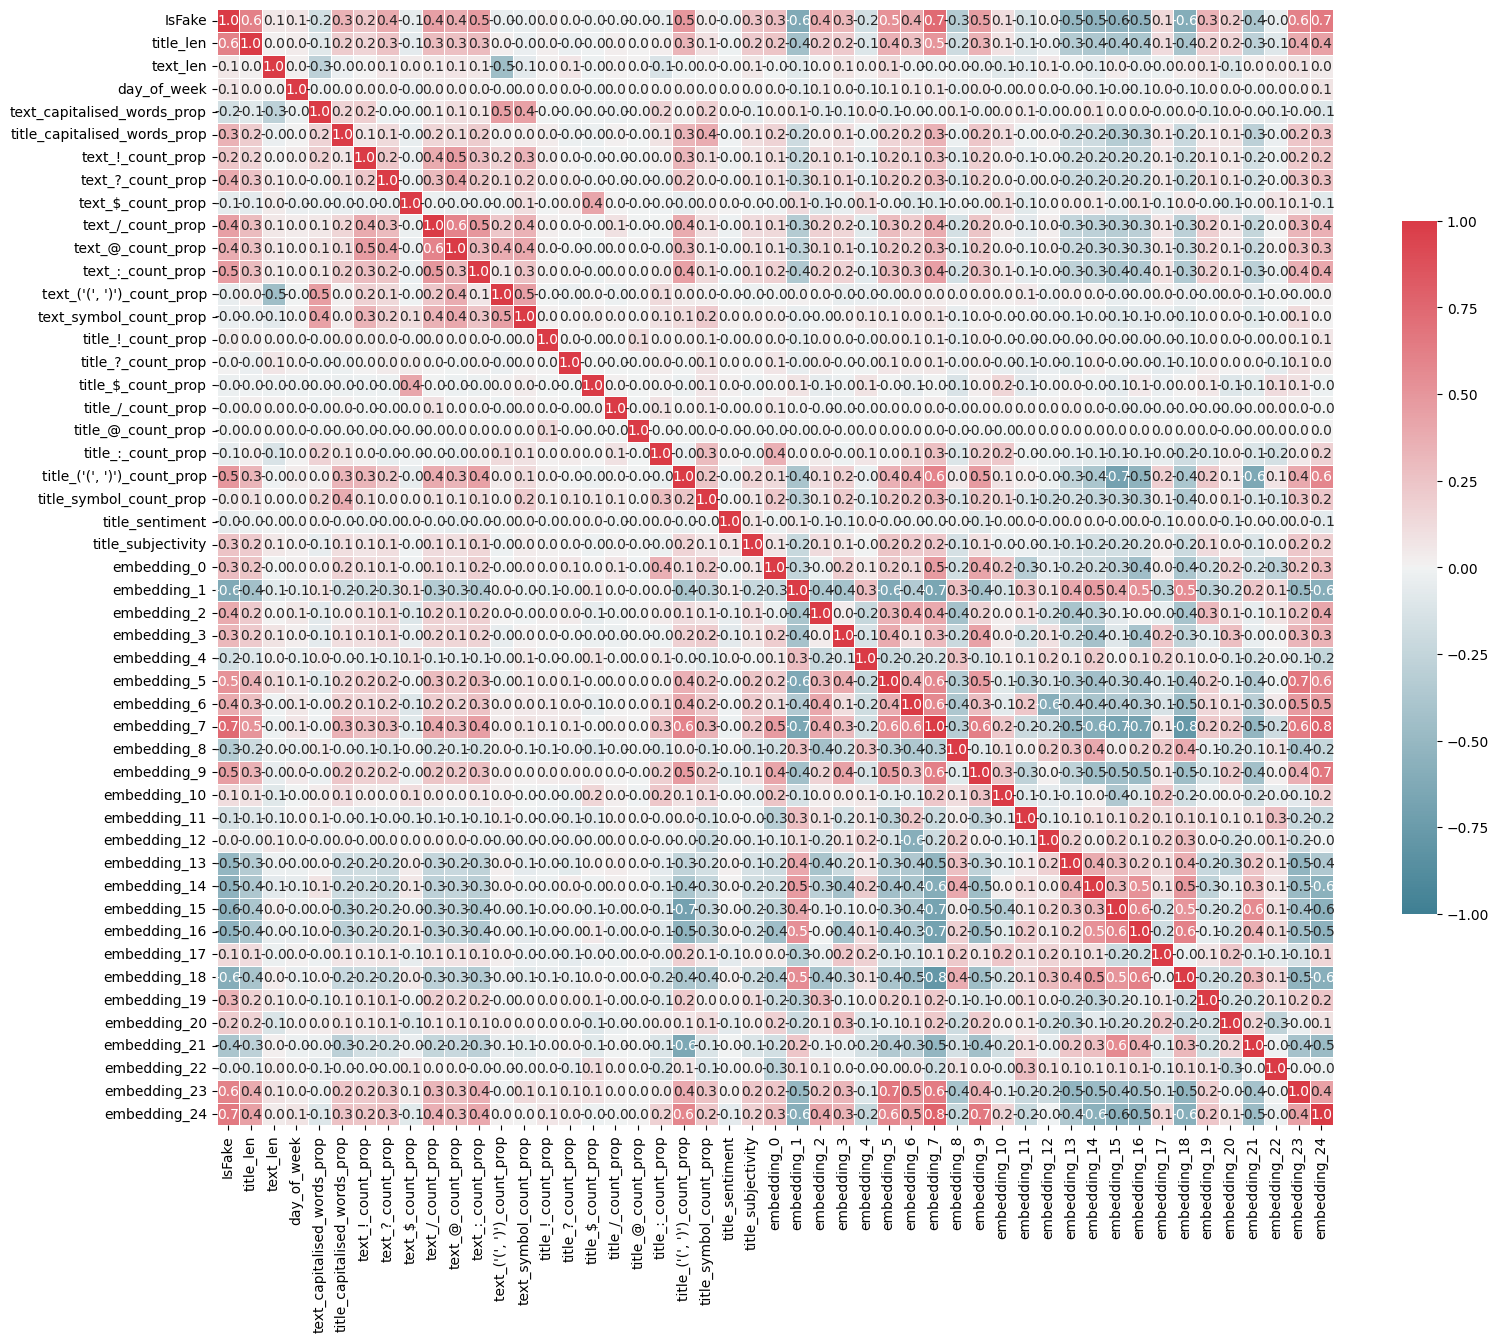

In [19]:
# Compute the correlation matrix
corr = df.iloc[:, 5:].astype(float).corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, annot=True, fmt='.1f', cbar_kws={"shrink": .5})

plt.show()

Areas for further investigation (outside of current scope):
- N-gram analysis
- Investigate feature drift over time

## Create Training Data

Training data is created by removing all original columns from the dataset (we will only be using the engineered features and word embeddings) and then splitting the data into train and test.

I have chosen a 20% split for my reserved test set, the trade-off here is between a more predictive model (large training set), and a robust confidence in our results (large test set).

For our task, I am satisfied with the performance of the model using the typical 20%, but I could decide to alter this if I was unsatisfied, however this would result in the need for greater caution regarding our results.

Additionally, I have decided not to shuffle the data before splitting, as my data is in `date` order and I want to ensure that my test data is strictly after my training data, as this reduces the risk of temporal biases in my results - giving confidence that the model can accurately predict on unseen future data.

In [20]:

model_df = df.sort_values('date').drop(['title', 'text', 'date', 'subject', 'index'], axis=1)

target_col = 'IsFake'

X = model_df.drop([target_col], axis=1)  # Features
X.columns = X.columns.astype(str)
y = model_df[target_col]  # Target variable

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Train Models

For model training, I have decided to craft two classifiers:
- Logistic Regression - a simple linear classification model, with highly interpretable outputs and fast inference.
- LightGBM - a more complex, gradient-boosted tree-based classifier, that is less interpretable but tends to provide better predictions.

My training pipeline works as so:
1. Define preprocessing steps (imputation, scaling)
   - Impute missing values with the median for that feature.
   - Scale features to between 0-1, this helps to avoid overfitting.
2. Set up cross-validation splits for evaluation
   - Here we use Stratified 5-fold validation, spliting the training data into five chunks and validating the predictive power using each chunk as a validation set.
   - This is conducted on a stratified sample, i.e. we ensure an identical ratio of real-fake articles in each chunk.
3. Build a grid search or randomized search object to tune hyperparameters
   - Grid search: exhaustively attempts all hyperparameter combinations.
   - Random search: randomly attempts feature combinations for a number of iterations. 
   - The choice between search methods can depend on the complexity of an individual run, the number of parameters tested, and whether parameters are categorical (defined set of values) or continuous (infinite set of values).
     - Given the discrete parameter set and relatively low compute required for training - Logistic regression was conducted using grid search.
4. Fit the search object on the training data


In [21]:
def build_pipeline(model, params, search_type="grid", n_iter=None,
                   scoring='f1', cv_folds=5, random_state=1):
    # Define the preprocessing pipeline.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Create the full pipeline with the model.
    pipeline = Pipeline(steps=[
        ('transformer', numeric_transformer),
        ('classifier', model)
    ])

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True,
                         random_state=random_state)
    # Choose the search method based on the provided argument.
    if search_type == "grid":
        search = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, cv=cv,
                              scoring=scoring, verbose=1)
    elif search_type == "random":
        if n_iter is None:
            raise ValueError("n_iter must be set when search_type is 'random'")
        search = RandomizedSearchCV(pipeline, param_distributions=params,
                                    n_jobs=-1, n_iter=n_iter,
                                    random_state=random_state, cv=cv,
                                    scoring=scoring, verbose=1)
    else:
        raise ValueError("search_type should be 'grid' or 'random'")

    return search


# Logistic Regression pipeline
log_reg = LogisticRegression(
    random_state=SEED, solver='liblinear', class_weight='balanced')
log_reg_params = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
}
log_reg_search = build_pipeline(
    log_reg, log_reg_params, search_type="grid", random_state=SEED)
log_reg_search.fit(X_train, y_train)

# LightGBM pipeline
lgbm = LGBMClassifier(random_state=SEED)
lgbm_params = {
    'classifier__num_leaves': sp_randint(20, 200),
    'classifier__min_child_samples': sp_randint(20, 500),
    'classifier__min_child_weight': sp_uniform(0.001, 0.05),
    'classifier__subsample': sp_uniform(0.6, 0.4),
    'classifier__colsample_bytree': sp_uniform(0.6, 0.4)
}
lgbm_search = build_pipeline(
    lgbm, lgbm_params, search_type="random", n_iter=20, random_state=SEED)
lgbm_search.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 3928, number of negative: 16270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9980
[LightGBM] [Info] Number of data points in the train set: 20198, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194475 -> initscore=-1.421193
[LightGBM] [Info] Start training from score -1.421193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('transformer',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer(strategy='median')),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('classifier',
                                              LGBMClassifier(random_state=1))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': <scipy.stats._distn...
                                        'classifier__min_child_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000275040A3FD0>,
                                        'classifier__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000274FF844850>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002750417BD00>},
                   random_state=1, scoring='f1', verbose=1)

## Model Evaluation

Now we will compute common metrics of classification accuracy on both of our models.

In [22]:
print("Logistic Regression Results:")
y_pred_prob_1 = log_reg_search.predict_proba(X_test)[:, 1]
y_pred_1 = (y_pred_prob_1 > 0.5).astype(float)
model_1_results = utils.get_binary_clf_eval_metrics(y_test, y_pred_1)
failures_model_1 = X_test[y_pred_1 != y_test].copy()

print("\n\nLightGBM Results:")
y_pred_prob_2 = lgbm_search.predict_proba(X_test)[:, 1]
y_pred_2 = (y_pred_prob_2 > 0.5).astype(int)
model_2_results = utils.get_binary_clf_eval_metrics(y_test, y_pred_2)
failures_model_2 = X_test[y_pred_2 != y_test].copy()

Logistic Regression Results:
Accuracy: 0.9968
Balanced Accuracy: 0.9984
Precision: 0.8889
Recall: 1.0000
F1 Score: 0.9412
Confusion Matrix:
 [[4906   16]
 [   0  128]]


LightGBM Results:
Accuracy: 0.9990
Balanced Accuracy: 0.9995
Precision: 0.9624
Recall: 1.0000
F1 Score: 0.9808
Confusion Matrix:
 [[4917    5]
 [   0  128]]


Highlights:
- Both models perform very well overall, with accuracy over 99% and balanced accuracy over 99.8%. LightGBM slightly outperforms logistic regression.
- Precision is higher for LightGBM at 0.9624 vs 0.8889 for logistic regression. This indicates LightGBM has fewer false positives.
- Recall is perfect for both models at 1.0, meaning no false negatives. All true positive cases are correctly classified.
- F1 score reflects precision and recall, with LightGBM achieving a higher 0.9808 vs 0.9412. This further demonstrates LightGBM's better balance of precision and recall.
- In the confusion matrices, LightGBM correctly classifies more true negatives compared to logistic regression (4917 vs 4906). It makes fewer mistakes in true negative prediction.
- Both models classify all 128 true positives correctly, evident in the 0 false negatives.

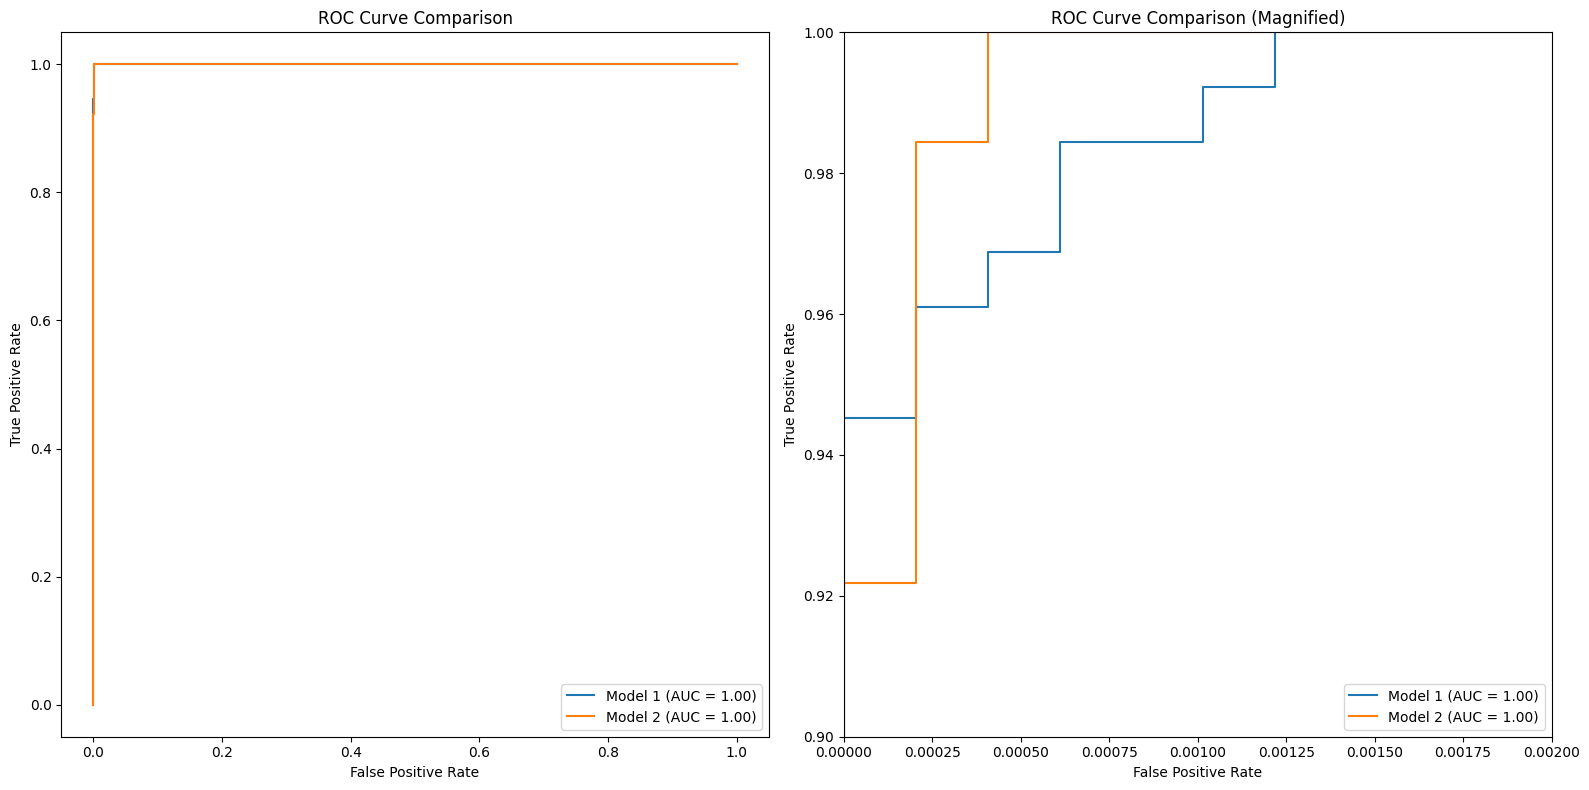

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8)) 

RocCurveDisplay.from_predictions(y_test, y_pred_prob_1, name="Model 1", ax=ax[0])
RocCurveDisplay.from_predictions(y_test, y_pred_prob_2, name="Model 2", ax=ax[0])

ax[0].set_title("ROC Curve Comparison")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")

RocCurveDisplay.from_predictions(y_test, y_pred_prob_1, name="Model 1", ax=ax[1])
RocCurveDisplay.from_predictions(y_test, y_pred_prob_2, name="Model 2", ax=ax[1])

ax[1].legend(loc="lower right")

ax[1].set_xlim(0, 0.002)
ax[1].set_ylim(0.9, 1)

ax[1].set_title("ROC Curve Comparison (Magnified)")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")

fig.tight_layout()

The ROC curve illustrates the trade-off between false positives and false negatives when classifying articles as fake or legitimate.

Focusing on Model 2 (LightGBM):
- We can achieve zero false positives - correctly classifying all legitimate articles - but at an 8% false negative rate. That is, nearly 8% of fake articles are misclassified as legitimate.
- Conversely, wcan ensure zero false negatives - correctly flagging 100% of fake articles as fake - but with a 0.05% false positive rate. Here, around 0.05% of legitimate articles are incorrectly classified as fake.

Given these trade-offs, ensemble modeling may be advantageous. Model 1 has superior performance at lower thresholds, minimising false negatives. Meanwhile, Model 2 works better at higher thresholds to reduce false positives.

## Explainability

Here, I display the coefficients for the logistic regression model and feature importances for the LightGBM model.

Logistic Regression is a directly explainable model, with its coefficients being directly observable.

LightGBM is not as directly explainable in the same way, however, we can get the "importance" of each feature by normalising the contributions across all trees in the model.

This distiction gives Logistic Regression the upper hand in explainability as:
1. The coefficent sign is meaningful (a negative sign indicates an inverse relationship between the feature and outcome scoring).
2. The features have a monotonic impact (if a feature is positive, every unit increase in the feature will increase the outcome scoring).

Neither of these factors hold true for LightGBM.

As such, despite the improved accuracy of LightGBM, it is useful for us to consider the both models as they each have their own strengths.

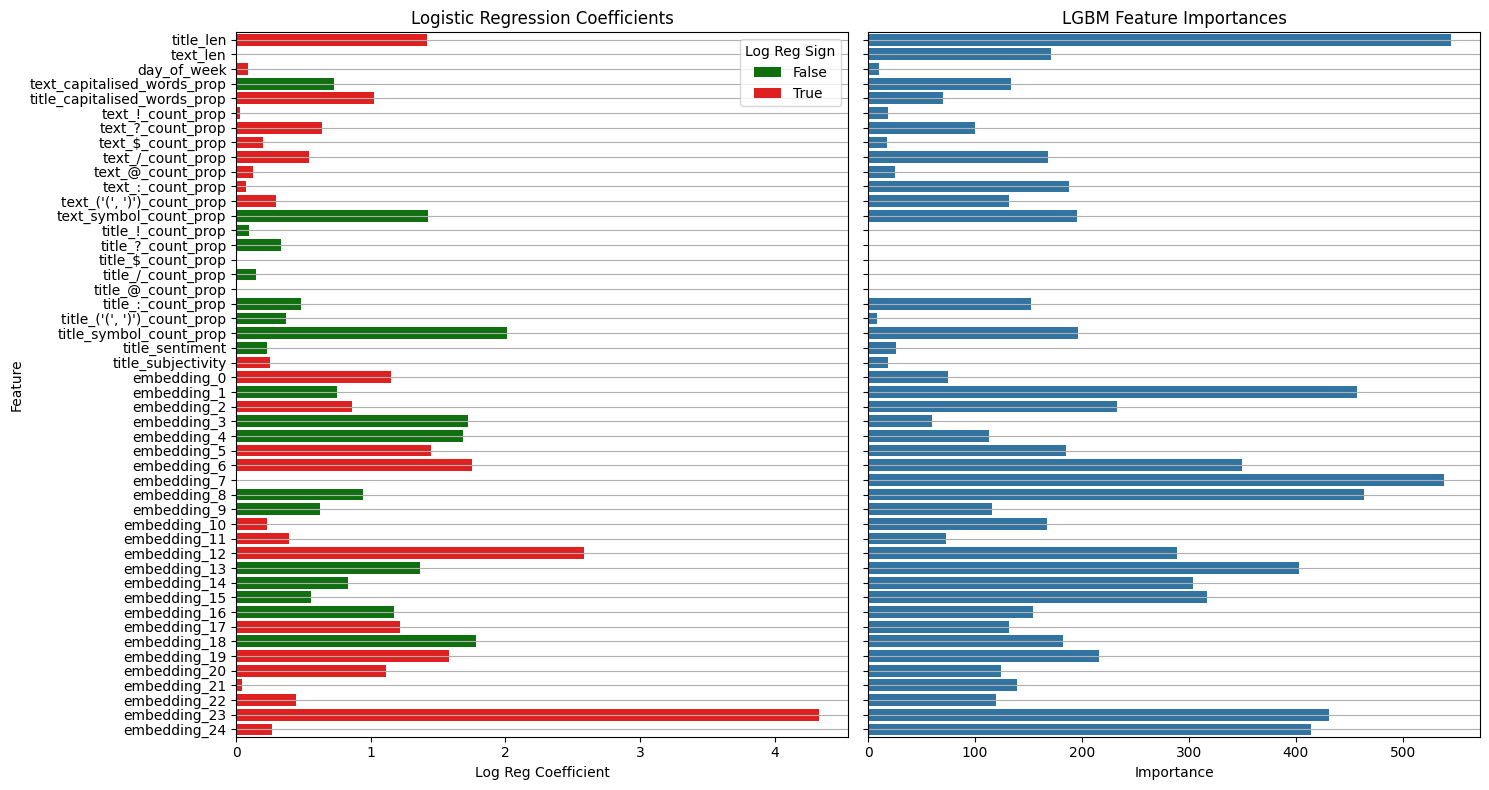

In [24]:
# Logistic Regression coefficients
logreg_model = log_reg_search.best_estimator_.named_steps['classifier']
logreg_coefficients = logreg_model.coef_.flatten()

# LightGBM feature importances
best_lgbm_model = lgbm_search.best_estimator_.named_steps['classifier']
lgbm_feature_importances = best_lgbm_model.feature_importances_

importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Log Reg Coefficient': logreg_coefficients,
    'LGBM Importance': lgbm_feature_importances
})

# Show log reg bars as absolute values for ease of comparison with LGBM
importances_df['Log Reg Coefficient (Abs)'] = abs(
    importances_df['Log Reg Coefficient'])

# Colour log reg bars by sign
importances_df['Log Reg Sign'] = importances_df['Log Reg Coefficient'] > 0
color_map = {False: 'red', True: 'green'}
importances_df['Log Reg Colour'] = importances_df['Log Reg Sign'].map(color_map)

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharey=True)


# Plot the Logistic Regression coefficients
sns.barplot(y='Feature', x='Log Reg Coefficient (Abs)', hue='Log Reg Sign', 
            palette=list(importances_df['Log Reg Colour'].unique()), 
            data=importances_df, ax=axs[0])
axs[0].set_title('Logistic Regression Coefficients')
axs[0].set_xlabel('Log Reg Coefficient')

# Plot for LGBM feature importances
sns.barplot(y='Feature', x='LGBM Importance', data=importances_df, ax=axs[1])
axs[1].set_title('LGBM Feature Importances')
axs[1].set_xlabel('Importance')
axs[1].set_ylabel('LGBM Importance')


# Add vertical gridlines to both plots
axs[0].yaxis.grid(True)
axs[1].yaxis.grid(True)

plt.tight_layout()
plt.show()

Insights:
- Both models give similar importance to the feature sets.
-  Both embeddings and engineered features have been utilised by both models, suggesting that engineered features contribute significantly to the output.
-  Of the engineered features, both models suggest that the title length, and use of symbols in the text and title are the most valuable contributors to the outcome.
-  Use of specific symbols (`!`, `?`, `$`, `/`, `@`), while valuable when parsing the text. Have negligable impact on the outcome when used in the title (LightGBM).
   -  Further interations of this system may be made more robust if these features were removed entirely.
-  Evidently, the embedding features on aggregate are the most predictive.

## Evaluating Failures

In this section, I will do some simple analysis of the failures in the test set for the LightGBM model and render the Shapley values in order to get some insight into the cause of some of these failures.

In [25]:
# Identify the type (FP/FN) of failures
fail_type = y_test[y_pred_2 != y_test]
failures_model_2['Type'] = fail_type.map({True: 'FN', False: 'FP'})

failures_model_2['Score'] = y_pred_prob_2[y_pred_2 != y_test]

failures_model_2.groupby("Type").size()

Type
FP    5
dtype: int64

All LightGBM failures are False Positives.

Depending on the scope of the problem, it is important to evaluate the relative cost of FP vs FN, i.e. are we more concerned with incorrectly identifying fake articles or not mislabelling legitimate articles.

While this is context dependent, I would suggest that if this is used to provide warnings to end users, that our case, where all errors are FP, is better than the alternative, given that it would be worse for users to read misinformation thinking it is true, than to introduce unnecessary warnings or increase skepticism of a legitimate article.

Next we will look at the scores for each of the failures, as a quick check for how close we were to the decision boundary.

In [26]:
# Score of each failure
failures_model_2[['Type', 'Score']]

Type     Score
15295   FP  0.503094
728     FP  0.529172
532     FP  0.569424
13484   FP  0.992866
13186   FP  0.998050

Interestingly, it seems that for three of the failures, the score was close to the decision boundary - suggesting with some light tuning these could have been correctly identified.

However, in two cases the score was significantly higher - indicating a strong likelihood to be fake.

As there are only a small number of failed observations, I will visualise the contribution of each feature to the decision outcome in all failed cases by using Shapley values.

Failure 1:


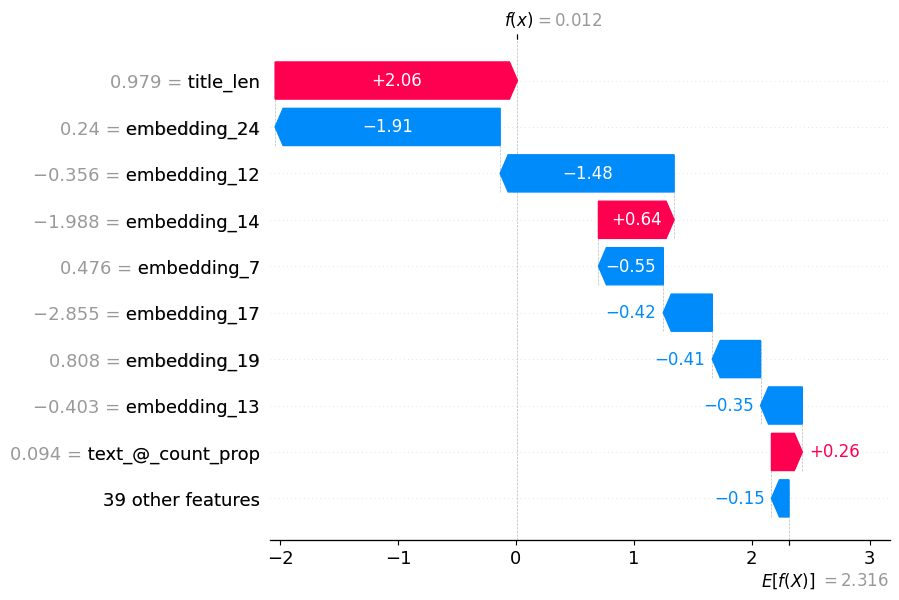

Failure 2:


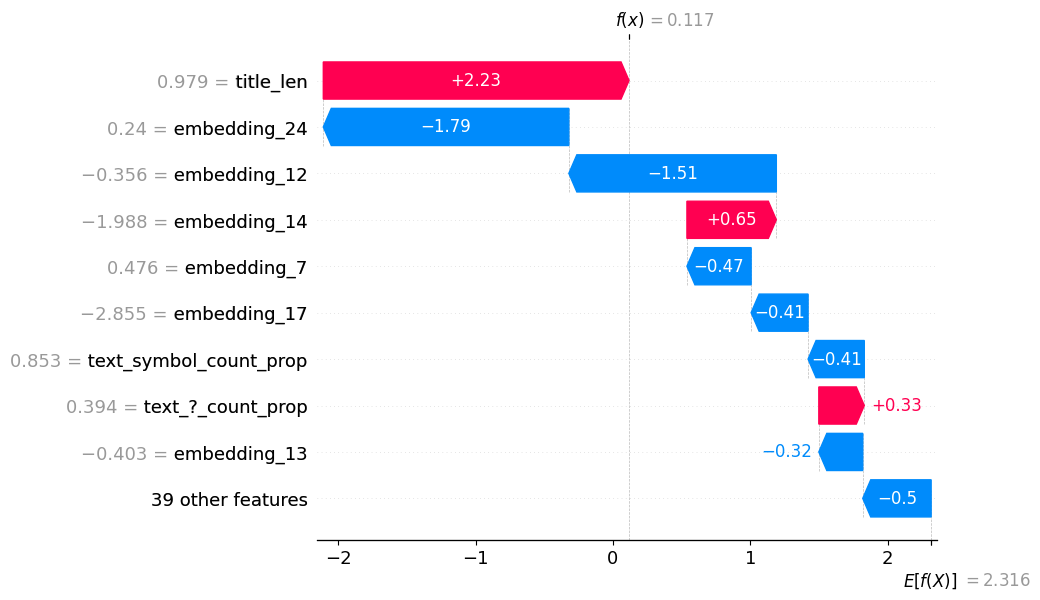

Failure 3:


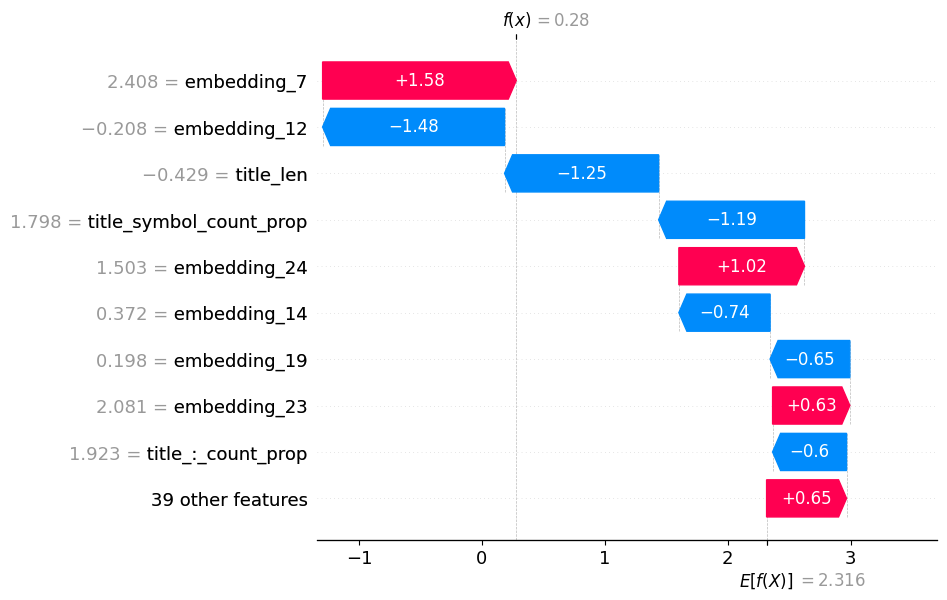

Failure 4:


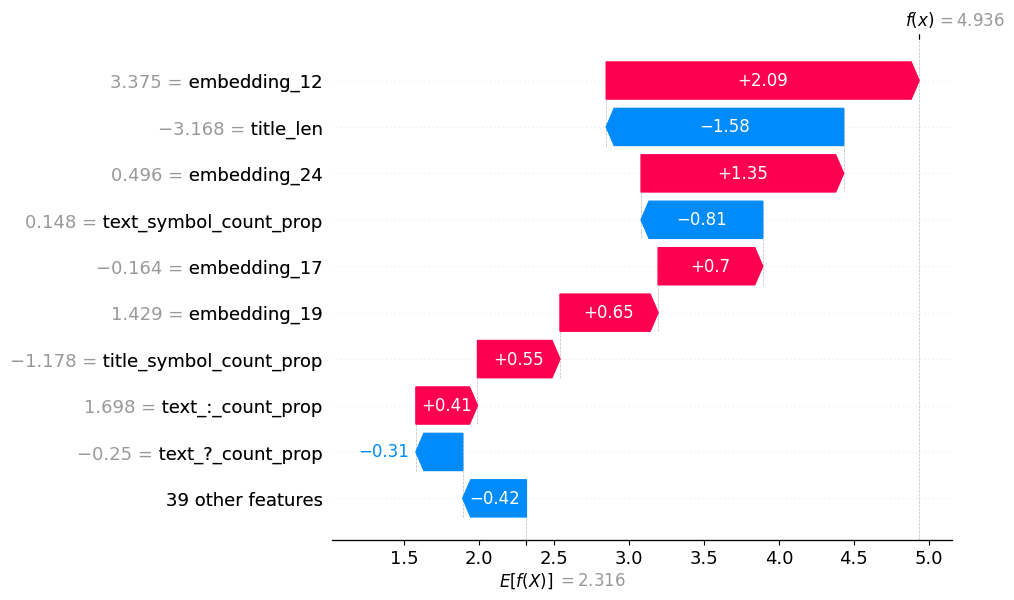

Failure 5:


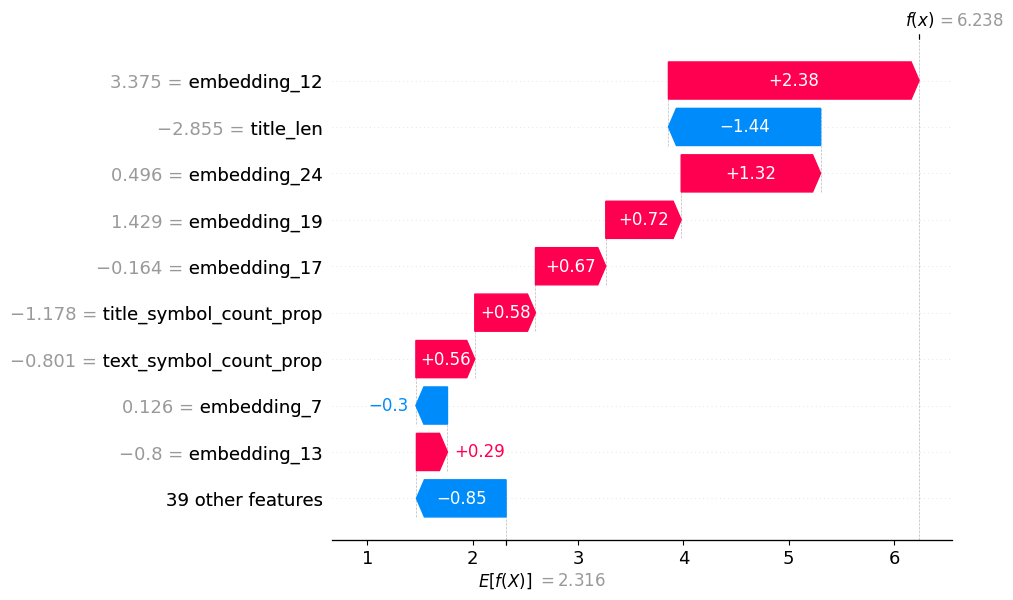

In [27]:
# Create explainer for the LGBM model
indices_of_interest =[13484]
fp_rows = pd.DataFrame(lgbm_search.best_estimator_.named_steps['transformer'].transform(failures_model_2.drop(['Type', 'Score'], axis=1)), columns=X.columns)


# Create explainer
explainer = shap.Explainer(lgbm_search.best_estimator_.named_steps['classifier'], fp_rows)
shap_values = explainer(fp_rows)

# Make decision plots
for i in range(len(fp_rows)):
    print(f"Failure {i+1}:")
    shap.plots.waterfall(shap_values[i])


Insights:
- In first two instances, the title length was the key driver in incorrect classification.
- In the third instance, one particular embedding (`7`) drove the majority of the effect.
- In the last two cases, the significant contributions were made by a number of features, including text embeddings (`12` in particular) and the relative prevalence of symbols in the text.

As a follow-up step, the above plots could be used to assist in the development of further models in the next phase of work, generating features and introducing careful regularisation to reduce the impact of the problem features.

## Inference Speed

In [28]:
# Number of inferences
n_inf = 1_000_000

np.random.random((n_inf, X.shape[1]))
t1 = time.time()
log_reg_search.best_estimator_.named_steps['classifier'].predict(
    np.random.random((1_000_000, X.shape[1])))
t2 = time.time()
lr_inf = 1000*(t2 - t1) / n_inf
print(f"Logistic Regression Pipeline: {lr_inf:.5f}ms / inference")

t1 = time.time()
lgbm_search.best_estimator_.named_steps['classifier'].predict(
    np.random.random((1_000_000, X.shape[1])))
t2 = time.time()
lgbm_inf = 1000*(t2 - t1) / n_inf
print(f"LightGBM Pipeline: {lgbm_inf:.5f}ms / inference")

print(
    f"Logistic Regression is {lgbm_inf/lr_inf:.1f}x faster at inference time.")


Logistic Regression Pipeline: 0.00045ms / inference
LightGBM Pipeline: 0.00136ms / inference
Logistic Regression is 3.0x faster at inference time.


Outcomes:
- Both algorithms have fast inference times, able to compute thousands of inferences per second.
- Logistic regression has significant improvements over LightGBM in inference performance.
  - In high-velocity environment, this could prove to be a deciding factor in which model to deploy.

## Conclusion:
- Run-time:
  - With resource downloads (GloVe, stopwords):
  - Without resource downloads:
- Inference Per Record:
  - **0.00008 seconds** - feature engineering.
  - **0.00125 milliseconds** - model prediction (LightGBM).
  - The model is lightweight and suitable to be deployed for a production application in a high-velocity environment.
- Test F1 Score:
  - Logistic Regression Model: **0.94**
  - LightGBM Model: **0.98**

## Potential Future Improvements:
- Further Exploratory Analysis: n-grams, topic modelling, etc.
- Bayesian Search for more sophisticated hyperparameter optimisation.
- Test performance with a wider range of classifier types (SVM, Naive Bayes, Neural Networks).
- Recursive Feature Elimination - remove features that may not be improving generality.
- Further feature engineering - misspellings, expletives, readability, named entities, etc.
- Experiment with embedding type and pooling (Word2vec, BERT, OpenAI Ada)
- Investigate Feature Drift - is future data following the same patterns as training data.
- Investigate potential bias in data collection process.
- More detailed investigation of failures.